In [1]:
import glob

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import metpy
import cartopy.feature as cfeature

from tqdm.notebook import tqdm

EPA data downloaded from here: [https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

In [2]:
xr.set_options(keep_attrs=True)

In [3]:
dates = pd.date_range(start='2021-01-01', end='2022-01-01', freq='1d', inclusive="left", tz='GMT').values
files = {}
for i in dates:
    date = f'{pd.to_datetime(i).dayofyear:03}'
    files[date] = sorted(glob.glob(f'/Volumes/Shores/GOES/AODC/averages/2021/{date}/*.nc'))

In [4]:
with xr.open_dataset(files['001'][14]) as aod:
    aod.load()

In [5]:
geo = aod.metpy.parse_cf('AOD').metpy.cartopy_crs
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

In [6]:
geo

<Derived Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +rf=298.2 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
plate

<Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
equal_area

<Derived Projected CRS: +proj=aea +ellps=WGS84 +lon_0=-98.5795 +lat_0=39.8 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Matching AOD

In [134]:
files = sorted(glob.glob('/Volumes/Shores/GOES/AODC/averages/2021/daily/*.nc'))

In [63]:
df = pd.read_csv('/Users/kyle/Downloads/daily_88101_2021.csv', parse_dates=['Date Local'])

df.rename(columns = {
    'Date Local':'time', 
    'Arithmetic Mean': 'value',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace = True)

keep = ['latitude', 'longitude', 'time', 'value','Local Site Name', 'Address', 'State Name', 'County Name','City Name', 'POC']
df.drop(columns=df.columns.difference(keep),inplace=True)

df = df.loc[df.value >= 0]

In [65]:
df

,POC,latitude,longitude,time,value,Local Site Name,Address,State Name,County Name,City Name
0,1,30.497478,-87.880258,2021-01-01,6.4,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope
1,1,30.497478,-87.880258,2021-01-07,5.7,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope
2,1,30.497478,-87.880258,2021-01-13,11.0,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope
3,1,30.497478,-87.880258,2021-01-16,5.1,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope
4,1,30.497478,-87.880258,2021-01-19,12.7,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope
...,...,...,...,...,...,...,...,...,...,...
588533,3,32.633671,-115.504995,2021-12-27,19.9,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali
588534,3,32.633671,-115.504995,2021-12-28,6.1,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali
588535,3,32.633671,-115.504995,2021-12-29,14.6,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali
588536,3,32.633671,-115.504995,2021-12-30,13.2,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali


In [66]:
transformed = geo.transform_points(src_crs=plate, x=df['longitude'], y=df['latitude'])
df['proj_longitude'] = transformed[:,0]
df['proj_latitude'] = transformed[:,1]

In [67]:
sat_h = aod.goes_imager_projection.perspective_point_height
minx, maxx = aod.x.min().item() * sat_h, aod.x.max().item() * sat_h
miny, maxy = aod.y.min().item() * sat_h, aod.y.max().item() * sat_h

In [68]:
# drop locations that are not observable by GOES-16
df = df[
    (df.proj_longitude >= minx) & 
    (df.proj_longitude <= maxx) & 
    (df.proj_latitude >= miny) & 
    (df.proj_latitude <= maxy)
]

In [69]:
df

,POC,latitude,longitude,time,value,Local Site Name,Address,State Name,County Name,City Name,proj_longitude,proj_latitude
0,1,30.497478,-87.880258,2021-01-01,6.4,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,-1.187314e+06,3.121229e+06
1,1,30.497478,-87.880258,2021-01-07,5.7,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,-1.187314e+06,3.121229e+06
2,1,30.497478,-87.880258,2021-01-13,11.0,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,-1.187314e+06,3.121229e+06
3,1,30.497478,-87.880258,2021-01-16,5.1,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,-1.187314e+06,3.121229e+06
4,1,30.497478,-87.880258,2021-01-19,12.7,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,-1.187314e+06,3.121229e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
588533,3,32.633671,-115.504995,2021-12-27,19.9,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali,-3.259868e+06,3.205527e+06
588534,3,32.633671,-115.504995,2021-12-28,6.1,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali,-3.259868e+06,3.205527e+06
588535,3,32.633671,-115.504995,2021-12-29,14.6,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali,-3.259868e+06,3.205527e+06
588536,3,32.633671,-115.504995,2021-12-30,13.2,"COBACH, CALLE GUADALAJARA JUST SOUTH OF AVENID...","COBACH, COLEGIO DE BACHILLERES, MEXICALI",Country Of Mexico,BAJA CALIFORNIA NORTE,Mexicali,-3.259868e+06,3.205527e+06


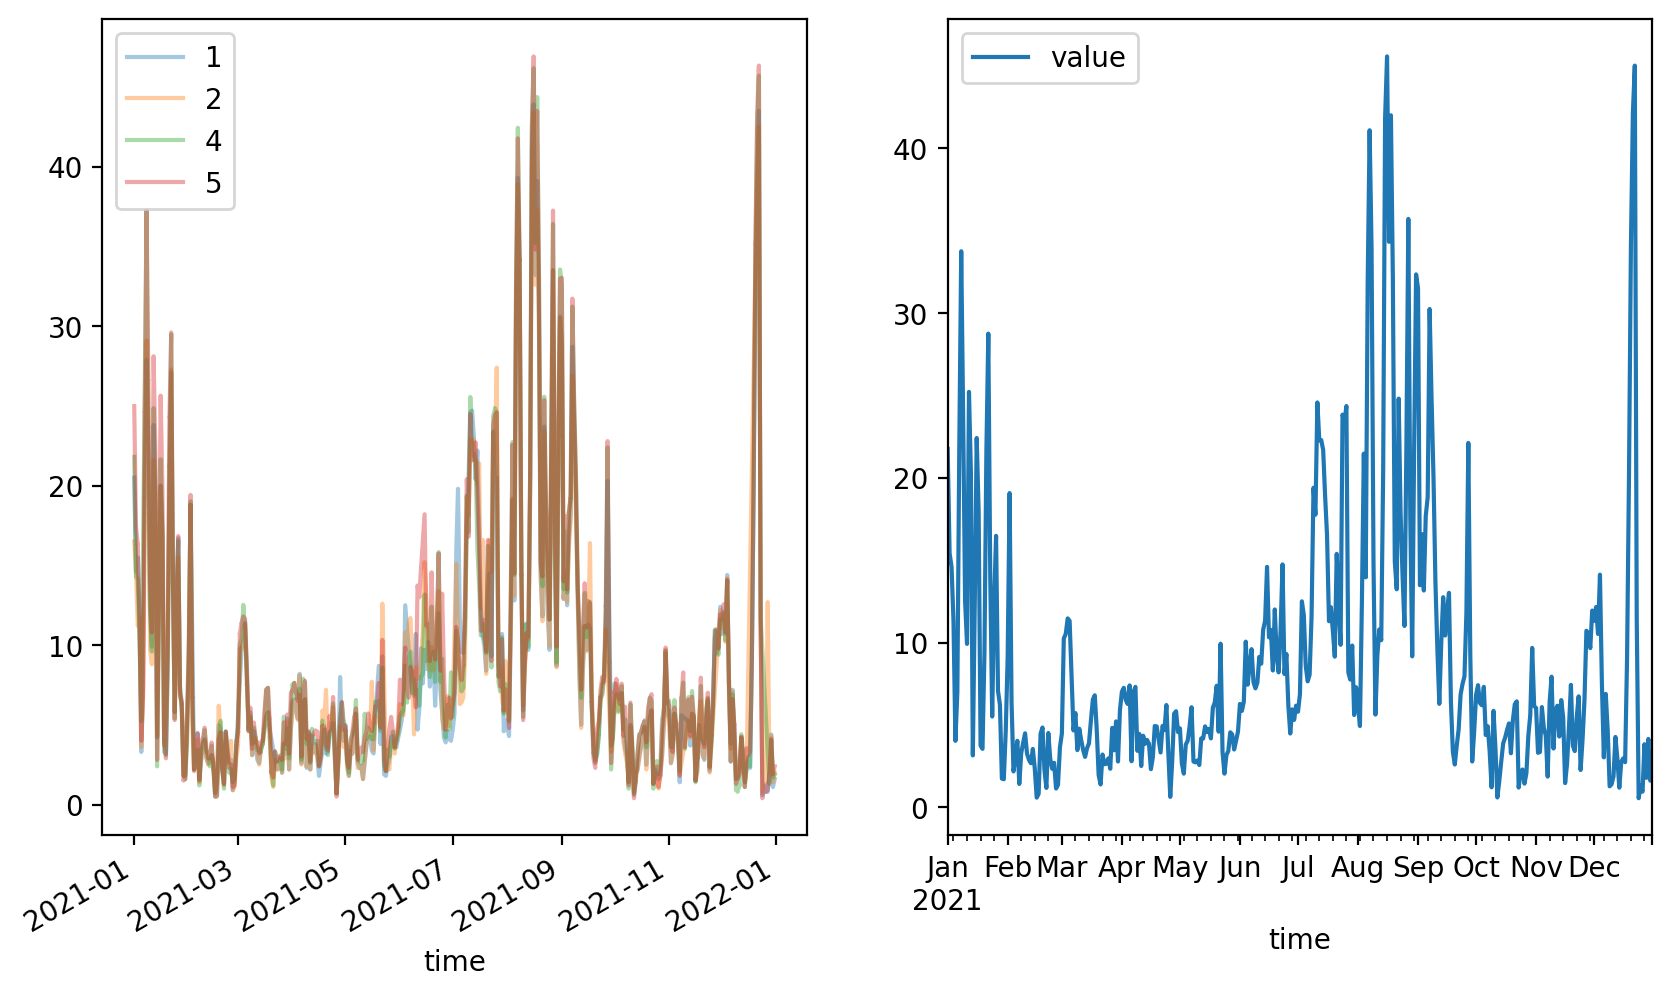

In [118]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
#     print(adf.POC.unique(), adf.POC.unique().shape)
    try:
        if adf.POC.unique().shape[0] > 3:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6), dpi=200)
            adf.set_index('time').sort_index().groupby('POC').value.plot(legend=True, ax=ax1, alpha=0.4)
            adf.groupby('time').mean().sort_index().value.plot(legend=True, ax=ax2)
#             x += 1
#             if x > 10:
            raise StopIteration
    except:
        break

In [126]:
# for locations that have more than one observation at the same time, average them
df = df.groupby(['longitude', 'latitude', 'time']).mean()
df.reset_index(inplace=True)

In [127]:
df

,longitude,latitude,time,POC,value,proj_longitude,proj_latitude
0,-124.179490,40.776780,2021-01-01,1.0,6.8,-3.330026e+06,3.787764e+06
1,-124.179490,40.776780,2021-01-04,1.0,6.4,-3.330026e+06,3.787764e+06
2,-124.179490,40.776780,2021-01-07,1.0,4.7,-3.330026e+06,3.787764e+06
3,-124.179490,40.776780,2021-01-10,1.0,15.2,-3.330026e+06,3.787764e+06
4,-124.179490,40.776780,2021-01-13,1.0,12.6,-3.330026e+06,3.787764e+06
...,...,...,...,...,...,...,...
274987,-64.784868,17.712474,2021-11-30,3.0,2.8,1.064197e+06,1.905148e+06
274988,-64.784868,17.712474,2021-12-06,3.0,3.8,1.064197e+06,1.905148e+06
274989,-64.784868,17.712474,2021-12-18,3.0,3.9,1.064197e+06,1.905148e+06
274990,-64.784868,17.712474,2021-12-24,3.0,3.5,1.064197e+06,1.905148e+06


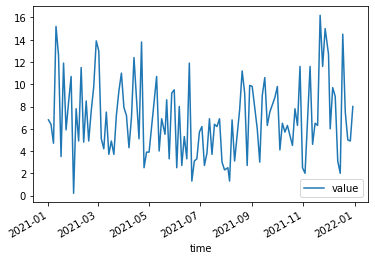

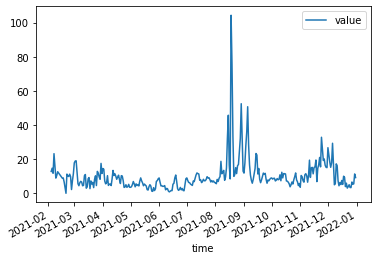

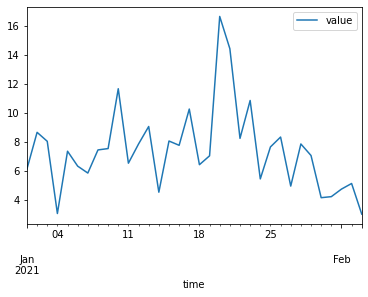

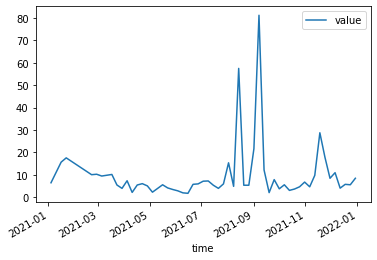

In [130]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
    try:
        fig, ax = plt.subplots()
        adf.set_index('time').sort_index().value.plot(legend=True, ax=ax)
        x += 1
        if x > 3:
            raise StopIteration
    except:
        break

In [131]:
empty = np.empty(df.shape[0])
empty[:] = np.nan
df['AOD'] = empty

In [132]:
df.set_index(['time', 'longitude', 'latitude'], inplace=True)
df.sort_index(inplace=True)

In [133]:
df

POC      value  proj_longitude  \
time       longitude   latitude                                    
2021-01-01 -124.179490 40.776780  1.0   6.800000   -3.330026e+06   
           -123.352640 39.411740  3.0   6.115217   -3.365376e+06   
           -123.206550 39.150470  3.0  14.612500   -3.372244e+06   
           -123.141352 44.067224  1.0   1.916666   -3.101428e+06   
           -123.083737 44.026312  1.0   2.000000   -3.101230e+06   
...                               ...        ...             ...   
2021-12-31 -70.268965  43.660246  3.0  10.837500    3.607385e+05   
           -68.772762  44.817398  2.0   7.133333    4.638504e+05   
           -68.321106  47.355332  2.0   9.204166    4.722074e+05   
           -68.260900  44.377050  3.0   0.300000    5.060534e+05   
           -68.016195  46.682299  2.0   7.725000    5.006529e+05   

                                  proj_latitude  AOD  
time       longitude   latitude                       
2021-01-01 -124.179490 40.776780   3.787764e+06  NaN  
           -123.352640 39.411740   3.693570e+06  NaN  
           -123.206550 39.150470   3.675155e+06  NaN  
           -123.141352 44.067224   4.022256e+06  NaN  
           -123.083737 44.026312   4.019869e+06  NaN  
...                                         ...  ...  
2021-12-31 -70.268965  43.660246   4.155362e+06  NaN  
           -68.772762  44.817398   4.230693e+06  NaN  
           -68.321106  47.355332   4.390150e+06  NaN  
           -68.260900  44.377050   4.201306e+06  NaN  
           -68.016195  46.682299   4.348521e+06  NaN  

[274992 rows x 5 columns]

In [143]:
matched_pm = 0
not_matched_pm = 0

pbar = tqdm(files)
for day_file in pbar:
    with xr.open_dataset(day_file) as ds:
        ds.load()
    sat_h = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)

    tm = pd.to_datetime(ds.t.item()).strftime('%Y-%m-%d')
    if np.isfinite(ds.AOD).any():
        sub = df.loc[tm]
        for (lon, lat), row in sub.iterrows():
            try:
                data = ds.sel(
                    x=row.proj_longitude, 
                    y=row.proj_latitude, 
                    method='nearest', 
                    tolerance=2000
                )
                if np.isfinite(data.AOD):
                    df.loc[(tm, lon, lat), 'AOD'] = data.AOD.item()
                    matched_pm += 1
            except Exception as e:
                not_matched_pm += 1

  0%|          | 0/365 [00:00<?, ?it/s]

In [146]:
df.reset_index().to_csv('data/matched.csv', index=False)

In [145]:
df.reset_index().dropna().to_csv('data/matched-no_nan.csv', index=False)

# Matching Meteorology

## EPA

In [ ]:
matched = pd.read_csv('data/matched-no_nan.csv', parse_dates=['time'])

In [173]:
met = ['data/daily_TEMP_2021.csv',
 'data/daily_PRESS_2021.csv',
 'data/daily_WIND_2021.csv',
 'data/daily_RH_DP_2021.csv',]
dfs = [
    pd.read_csv(f, 
        parse_dates=['Date Local'], 
        usecols=[
       'Latitude', 'Longitude', 'Parameter Name', 'Date Local',
       'Units of Measure', 'Arithmetic Mean'
        ]
) for f in met]

In [184]:
meteo = pd.concat(dfs, axis=0)

In [275]:
empty = np.empty(matched.shape[0])
empty[:] = np.nan
for c in meteo['Parameter Name'].unique():
    matched[c] = empty

In [274]:
meteo.reset_index(inplace=True)

In [276]:
meteo.set_index([ 'Parameter Name', 'Longitude', 'Latitude', 'Date Local'], inplace=True)
meteo

Units of Measure  \
Parameter Name      Longitude  Latitude Date Local                              
Outdoor Temperature -87.54350  31.09210 2021-01-01         Degrees Fahrenheit   
                                        2021-01-02         Degrees Fahrenheit   
                                        2021-01-03         Degrees Fahrenheit   
                                        2021-01-04         Degrees Fahrenheit   
                                        2021-01-05         Degrees Fahrenheit   
...                                                                       ...   
Relative Humidity   -104.20512 43.84539 2021-12-27  Percent relative humidity   
                                        2021-12-28  Percent relative humidity   
                                        2021-12-29  Percent relative humidity   
                                        2021-12-30  Percent relative humidity   
                                        2021-12-31  Percent relative humidity   

                                                    Arithmetic Mean  
Parameter Name      Longitude  Latitude Date Local                   
Outdoor Temperature -87.54350  31.09210 2021-01-01        63.875000  
                                        2021-01-02        51.141667  
                                        2021-01-03        44.666667  
                                        2021-01-04        48.120833  
                                        2021-01-05        50.079167  
...                                                             ...  
Relative Humidity   -104.20512 43.84539 2021-12-27        63.375000  
                                        2021-12-28        72.541667  
                                        2021-12-29        71.208333  
                                        2021-12-30        60.833333  
                                        2021-12-31        82.625000  

[1011396 rows x 2 columns]

In [277]:
matched.set_index(['longitude', 'latitude', 'time'], inplace=True)
matched

,,,POC,value,proj_longitude,proj_latitude,AOD,Outdoor Temperature,Barometric pressure,Wind Speed - Resultant,Wind Direction - Resultant,Relative Humidity,Dew Point
longitude,latitude,time,,,,,,,,,,,
-117.675930,33.630030,2021-01-01,1.000000,3.700000,-3.346970e+06,3.276413e+06,0.026075,NaN,NaN,NaN,NaN,NaN,NaN
-117.617220,34.030833,2021-01-01,2.333333,8.758333,-3.326257e+06,3.309417e+06,0.046046,NaN,NaN,NaN,NaN,NaN,NaN
-117.492010,34.100020,2021-01-01,1.000000,3.800000,-3.316060e+06,3.315712e+06,0.074804,NaN,NaN,NaN,NaN,NaN,NaN
-117.416010,33.999580,2021-01-01,6.333333,1.422222,-3.316039e+06,3.307956e+06,0.052775,NaN,NaN,NaN,NaN,NaN,NaN
-117.325540,34.510961,2021-01-01,1.500000,10.158333,-3.288587e+06,3.349871e+06,0.073041,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
-77.012816,38.875161,2021-12-31,1.000000,5.745833,-1.670613e+05,3.816162e+06,0.240285,NaN,NaN,NaN,NaN,NaN,NaN
-76.958072,38.895572,2021-12-31,1.000000,5.612500,-1.624668e+05,3.817712e+06,0.294921,NaN,NaN,NaN,NaN,NaN,NaN
-76.953426,38.894770,2021-12-31,1.000000,7.837500,-1.620836e+05,3.817653e+06,0.418024,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for col in meteo.index.levels[0]:
    sub = meteo.loc[col]
    for (lon, lat, time), adf in matched.groupby(['longitude', 'latitude', 'time']):
        try:
            matched.loc[(lon, lat, time), col] = sub.loc[(lon, lat, '2021-01-01'), 'Arithmetic Mean'].mean()
        except KeyError:
            continue

In [288]:
matched.reset_index().to_csv('data/matched-with-met.csv', index=False)

In [289]:
matched.describe()

,POC,value,proj_longitude,proj_latitude,AOD,Outdoor Temperature,Barometric pressure,Wind Speed - Resultant,Wind Direction - Resultant,Relative Humidity,Dew Point
count,132282.000000,132282.000000,1.322820e+05,1.322820e+05,132282.000000,46801.000000,22844.000000,43304.000000,43853.000000,30438.000000,3356.000000
mean,2.716325,8.802210,-1.189576e+06,3.667907e+06,0.272992,37.837671,985.377553,4.044254,179.913621,74.979610,28.877657
std,1.305879,5.746745,9.936727e+05,3.746341e+05,0.223329,11.820817,47.555525,2.286895,72.311485,20.271128,6.980519
min,1.000000,0.000000,-3.354953e+06,2.673276e+06,-0.049923,7.833333,747.141667,0.000000,0.000000,21.916667,10.791667
25%,2.000000,5.261218,-1.849956e+06,3.392689e+06,0.125381,29.666667,981.979167,2.262500,125.500000,66.625000,25.708333
50%,3.000000,7.533333,-9.699685e+05,3.766235e+06,0.217631,35.108333,993.837500,3.812500,175.166667,80.958333,32.666667
75%,3.000000,10.804166,-4.623692e+05,3.957464e+06,0.358187,45.558333,1014.911111,5.566667,234.666667,89.958333,33.333333
max,11.000000,222.410416,5.060534e+05,4.408975e+06,3.582377,76.583333,1084.387500,12.283333,333.320833,100.000000,38.500000


## ERA5 Land

In [9]:
with xr.open_dataset('/Volumes/Shores/ERA5/download-era5_land.nc') as ds:
    ds.load()

In [10]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 901, latitude: 501, time: 365)
Coordinates:
  * longitude  (longitude) float32 -135.0 -134.9 -134.8 ... -45.2 -45.1 -45.0
  * latitude   (latitude) float32 50.0 49.9 49.8 49.7 ... 0.3 0.2 0.1 -4.416e-13
  * time       (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    v10        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    d2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    lai_hv     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    lai_lv     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sp         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    tp         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-06 14:55:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
matched = pd.read_csv('data/matched-no_nan.csv', parse_dates=['time'])

In [12]:
empty = np.empty(matched.shape[0])
empty[:] = np.nan
for c in ds.data_vars:
    matched[c] = empty

In [13]:
matched

,time,longitude,latitude,POC,value,proj_longitude,proj_latitude,AOD,u10,v10,d2m,t2m,lai_hv,lai_lv,sp,tp
0,2021-01-01,-117.675930,33.630030,1.000000,3.700000,-3.346970e+06,3.276413e+06,0.026075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,-117.617220,34.030833,2.333333,8.758333,-3.326257e+06,3.309417e+06,0.046046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,-117.492010,34.100020,1.000000,3.800000,-3.316060e+06,3.315712e+06,0.074804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,-117.416010,33.999580,6.333333,1.422222,-3.316039e+06,3.307956e+06,0.052775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,-117.325540,34.510961,1.500000,10.158333,-3.288587e+06,3.349871e+06,0.073041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132277,2021-12-31,-77.012816,38.875161,1.000000,5.745833,-1.670613e+05,3.816162e+06,0.240285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132278,2021-12-31,-76.958072,38.895572,1.000000,5.612500,-1.624668e+05,3.817712e+06,0.294921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132279,2021-12-31,-76.953426,38.894770,1.000000,7.837500,-1.620836e+05,3.817653e+06,0.418024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132280,2021-12-31,-76.059210,43.052350,4.000000,12.216667,-8.180915e+04,4.115855e+06,0.211089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
matched.set_index(['longitude', 'latitude', 'time'], inplace=True)

In [28]:
matched.sort_index(inplace=True)

In [32]:
pbar = tqdm(matched.groupby(['longitude', 'latitude', 'time']))
for (lon, lat, time), _ in pbar:
    data = ds.sel(longitude=lon, latitude=lat, time=time, method='nearest')
    matched.loc[(lon, lat, time), "u10"] = data["u10"].item()
    matched.loc[(lon, lat, time), "v10"] = data["v10"].item()
    matched.loc[(lon, lat, time), "d2m"] = data["d2m"].item()
    matched.loc[(lon, lat, time), "t2m"] = data["t2m"].item()
    matched.loc[(lon, lat, time), "lai_hv"] = data["lai_hv"].item()
    matched.loc[(lon, lat, time), "lai_lv"] = data["lai_lv"].item()
    matched.loc[(lon, lat, time), "sp"] = data["sp"].item()
    matched.loc[(lon, lat, time), "tp"] = data["tp"].item()

  0%|          | 0/132282 [00:00<?, ?it/s]

In [34]:
matched.reset_index().to_csv('data/matched-with-met-era5-land.csv', index=False)

In [35]:
matched.reset_index().dropna().to_csv('data/matched-with-met-era5-land-no-nans.csv', index=False)

In [33]:
matched

POC      value  proj_longitude  \
longitude   latitude  time                                              
-117.675930 33.630030 2021-01-01  1.000000   3.700000   -3.346970e+06   
                      2021-01-04  1.000000  16.000000   -3.346970e+06   
                      2021-01-10  1.000000   4.700000   -3.346970e+06   
                      2021-01-12  3.000000   7.550000   -3.346970e+06   
                      2021-01-14  3.000000   7.127084   -3.346970e+06   
...                                    ...        ...             ...   
-68.016195  46.682299 2021-11-23  2.000000   2.928261    5.006529e+05   
                      2021-11-24  1.666667   1.549275    5.006529e+05   
                      2021-11-25  2.000000   9.725000    5.006529e+05   
                      2021-12-14  2.000000   1.500000    5.006529e+05   
                      2021-12-15  2.000000   3.225000    5.006529e+05   

                                  proj_latitude       AOD       u10       v10  \
longitude   latitude  time                                                      
-117.675930 33.630030 2021-01-01   3.276413e+06  0.026075 -1.077633 -2.977906   
                      2021-01-04   3.276413e+06  0.165248  0.027674 -1.163661   
                      2021-01-10   3.276413e+06  0.075717 -2.532230 -1.818331   
                      2021-01-12   3.276413e+06  0.032146 -2.210322 -1.396567   
                      2021-01-14   3.276413e+06 -0.000069 -1.854353 -1.918541   
...                                         ...       ...       ...       ...   
-68.016195  46.682299 2021-11-23   4.348521e+06  0.153064  1.513661 -2.042427   
                      2021-11-24   4.348521e+06  0.050908  2.572217 -3.949725   
                      2021-11-25   4.348521e+06  0.026942  1.448878 -2.332596   
                      2021-12-14   4.348521e+06  0.036800  4.730739 -4.472250   
                      2021-12-15   4.348521e+06  0.095249  1.779469 -1.936160   

                                         d2m         t2m    lai_hv    lai_lv  \
longitude   latitude  time                                                     
-117.675930 33.630030 2021-01-01  276.775940  282.467194  4.608634  2.416980   
                      2021-01-04  281.729828  281.769989  4.610749  2.420312   
                      2021-01-10  274.341705  282.241272  4.614869  2.426738   
                      2021-01-12  278.020599  281.532410  4.616204  2.428801   
                      2021-01-14  277.066895  283.391571  4.617651  2.431022   
...                                      ...         ...       ...       ...   
-68.016195  46.682299 2021-11-23  264.882172  270.338379  3.432402  1.716067   
                      2021-11-24  264.790070  269.574982  3.432180  1.715115   
                      2021-11-25  260.252960  269.937225  3.431846  1.714242   
                      2021-12-14  261.919952  270.343597  3.427838  1.695916   
                      2021-12-15  258.755554  263.814392  3.427616  1.694964   

                                             sp        tp  
longitude   latitude  time                                 
-117.675930 33.630030 2021-01-01  100737.046875  0.000000  
                      2021-01-04  101285.859375  0.000000  
                      2021-01-10  101195.578125  0.000000  
                      2021-01-12  101464.460938  0.000000  
                      2021-01-14  101181.937500  0.000000  
...                                         ...       ...  
-68.016195  46.682299 2021-11-23   98547.023438  0.000000  
                      2021-11-24   99285.476562  0.000021  
                      2021-11-25   99218.578125  0.000000  
                      2021-12-14   99689.453125  0.000107  
                      2021-12-15  101337.164062  0.000000  

[132282 rows x 13 columns]